# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [1]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

from ipyfilechooser import FileChooser
import folium

from tqdm import tqdm

#specific imports
from functions import set_output_dir, get_size, get_data_dict, merge_tiles

# Import the Timeseries class
from time_series import Timeseries
print(Timeseries.__doc__)


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together the data tiles with associated dates files, and their metadata. 
    It also allows for saving and loading the output rasters. 
    


In [2]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,2..n]

### Optional: select a name for your output folder. 

In [3]:
from os.path import expanduser
path = expanduser("~")

def g(directory):
    return(directory)
                          
output_directory_chooser = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)



FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [4]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    set_output_dir(output_directory_chooser)

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/
Defaulting to output directory name "output" 


# Load in data: if there are tiles in the directory, create a list and load per tile

In [5]:
# set paths to data
dates_path = os.path.join(timeseries_directory, "dates.csv")
data_list=[]
tile_paths = []

# check for tiles
file_list = os.listdir(timeseries_directory)
file_list.sort()
for file in file_list:
    if file.startswith('tile'):
        print(file)
        time_series_path =  timeseries_directory + file + "/"
        tile_paths.append(time_series_path)


tile-0000000000-0000000000
tile-0000000000-0000002048
tile-0000000000-0000004096
tile-0000000000-0000006144
tile-0000002048-0000000000
tile-0000002048-0000002048
tile-0000002048-0000004096
tile-0000002048-0000006144
tile-0000004096-0000000000
tile-0000004096-0000002048
tile-0000004096-0000004096
tile-0000004096-0000006144


In [6]:
# # Set up list of time series tiles and their metadata
if not tile_paths:
    print("No tiles, setting up data as one tile")
    ts_data = Timeseries(timeseries_directory, dates_path)
    data_list.append(ts_data)
    
else:
    print("Data consists of tiles, setting up tiles in 'data_list' ")
    for time_series_path in tile_paths:
        ts_data = Timeseries(time_series_path, dates_path)
        data_list.append(ts_data)

Data consists of tiles, setting up tiles in 'data_list' 


### Check some metadata of the created Timeseries class

In [7]:
# data_list = data_list[0:2]
#ts_data = data_list[0]
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
#ts_data.log_output_to_txt()

#data_list = data_list[0:6]
#data_list = data_list[3:6]
data_list

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358576


[Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000000000/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000002048/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000004096/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000006144/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000000000/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000002048/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000004096/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000006144/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_s

# Set parameters

In [8]:
# parameters
k = 3
freq = 365
trend = True
hfrac = 0.25
level = 0.05
position = (100,100)

backend = 'opencl'
verbose = 1
device_id = 0


# start_hist = datetime(2018, 1, 1)
# start_monitor = datetime(2019, 1, 1)
# end_monitor = datetime(2020, 1, 1)


# Select monitoring period

In [9]:
dates = ts_data.dates
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)


monitoring_period = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"50px"}))


history_period = widgets.interactive(h, 
                                     y=widgets.SelectionSlider(description="Start history period:", 
                                            options = options,
                                            style = {'description_width': 'initial'}))

display(monitoring_period)
display(history_period)

start monitoring period 2016-02-05 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 1657), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2016-02-05', Timestamp('…

In [10]:
start_monitor, end_monitor = monitoring_period.result
start_hist = history_period.result

if history_period.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

start_monitor = datetime(2018, 9, 14)

print("start monitor: ", start_monitor)
print("end monitor: ", end_monitor)
print("start history: ", start_hist)

start monitor:  2018-09-14 00:00:00
end monitor:  2020-08-19 00:00:00
start history:  2016-02-05 00:00:00


### Loop over tiles, (or single tile), in data_list
### Alternatively, if your means and breaks arrays already exist, skip this code and run load from file in the next block

In [12]:

# if you get a memory error, set this lower: 256, 128, 512
x_block = y_block = 256

# loading bar
with tqdm(total=len(data_list[5:])) as pbar1:
    
    # loop over tile(s) in the data_list
    for counter, ts_data in enumerate(data_list):
        pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(data_list)) )
        
        ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend=backend,verbose=verbose,device_id=device_id)
        ts_data.loop_blocks(x_block_size = x_block,y_block_size=y_block)
        print("##################### ", len(ts_data.cropped_dates), '###############')
        ts_data.get_bfast_parameters()
        ts_data.log_output_to_txt()
        ts_data.log_breaks_means_arrays()
        
        pbar1.update(counter)
pbar1.close()

# add warning for large block size, gets stuck? or so?

Processing tile 1 out of 12:   0%|          | 0/7 [00:00<?, ?it/s]
  0%|          | 0/64.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/64.0 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x42b60f0>]
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  256 ,  256
bytes required:  18991808512
start monitor:  2018-09-14 00:00:00
end monitor:  2020-08-19 00:00:00
start history:  2016-02-05 00:00:00
0 0 256 256


Processing blocks of tile::   2%|▏         | 1/64.0 [00:03<03:57,  3.77s/it]
Processing tile 1 out of 12:   0%|          | 0/7 [00:03<?, ?it/s]


KeyboardInterrupt: 

## If you want to load tiles 

In [11]:
for tile in data_list:
    print(tile.dir)
    
    # if you want to load in previously saved tiles
    tile.load_breaks_means_arrays_from_file()
    tile.start_hist = datetime(2018, 9, 14) # get these from log (automatically?) # probs save a dict as log
    tile.end_monitor = datetime(2020, 8, 19) 
    tile.crop_dates(dates)

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000000000/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000000000_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000000000_breaks.npy
/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000002048/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000002048_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000002048_breaks.npy
/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000004096/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000004096_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000004096_breaks.npy
/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000006144/
output_arrays/Time_series

### Check tiles for output quality

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000000000/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000000000_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000000000_breaks.npy
minus2s:  0
minus1s:  4192455
total 4194304
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.044083595275878906
amount of nans in means:  4191459
breaks datatype:  int32
means datatype:  float32


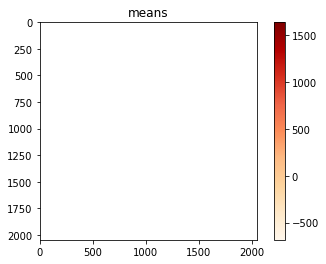

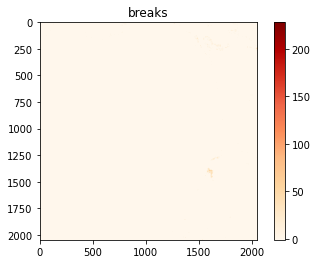

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000002048/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000002048_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000002048_breaks.npy
minus2s:  0
minus1s:  4188833
total 4194304
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.13043880462646484
amount of nans in means:  4187879
breaks datatype:  int32
means datatype:  float32


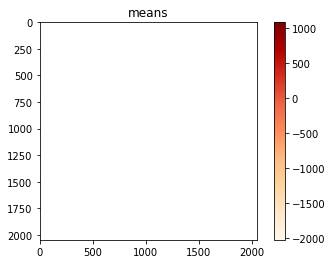

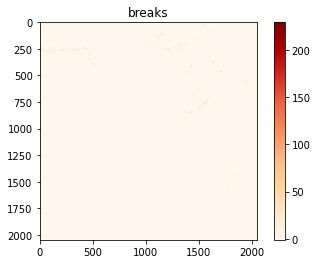

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000004096/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000004096_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000004096_breaks.npy
minus2s:  0
minus1s:  4182045
total 4194304
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.29227733612060547
amount of nans in means:  4184788
breaks datatype:  int32
means datatype:  float32


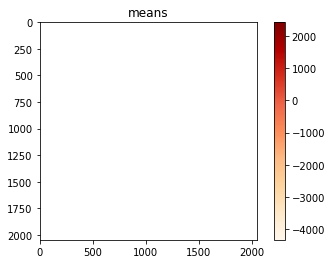

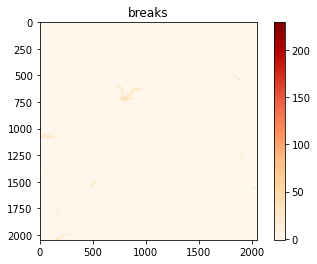

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000006144/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000006144_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000000000-0000006144_breaks.npy
minus2s:  0
minus1s:  2230955
total 2273280
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 1.8618471987612615
amount of nans in means:  2180408
breaks datatype:  int32
means datatype:  float32


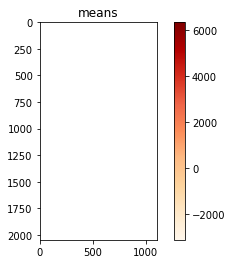

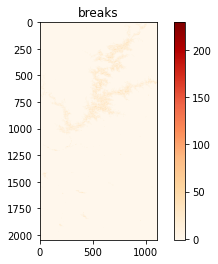

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000000000/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000002048-0000000000_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000002048-0000000000_breaks.npy
minus2s:  0
minus1s:  4192580
total 4194304
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.041103363037109375
amount of nans in means:  4191779
breaks datatype:  int32
means datatype:  float32


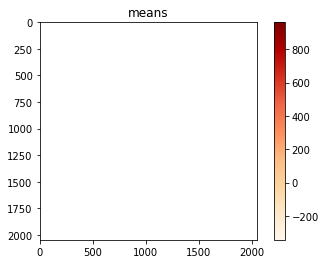

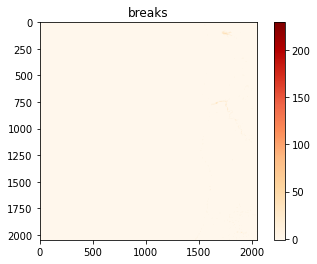

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000002048/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000002048-0000002048_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000002048-0000002048_breaks.npy
minus2s:  0
minus1s:  4187848
total 4194304
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.15392303466796875
amount of nans in means:  4184399
breaks datatype:  int32
means datatype:  float32


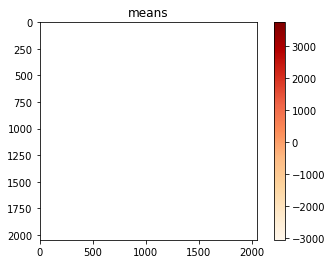

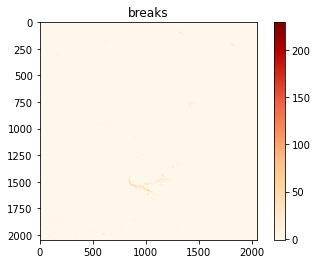

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000004096/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000002048-0000004096_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000002048-0000004096_breaks.npy
minus2s:  0
minus1s:  4193136
total 4194304
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.0278472900390625
amount of nans in means:  4193067
breaks datatype:  int32
means datatype:  float32


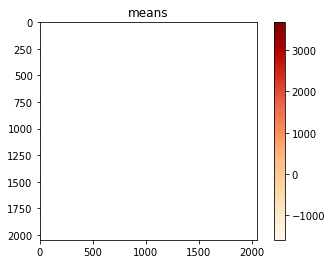

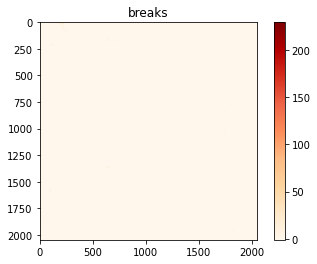

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000006144/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000002048-0000006144_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000002048-0000006144_breaks.npy
minus2s:  0
minus1s:  2271903
total 2273280
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.06057326858108108
amount of nans in means:  2271184
breaks datatype:  int32
means datatype:  float32


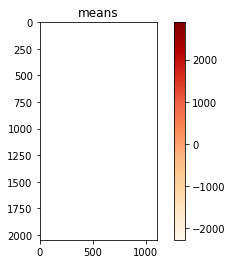

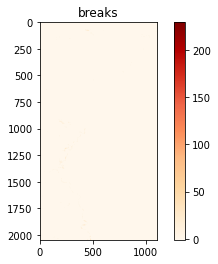

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000004096-0000000000/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000004096-0000000000_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000004096-0000000000_breaks.npy
minus2s:  0
minus1s:  3155403
total 3158016
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.08274182271400778
amount of nans in means:  3155801
breaks datatype:  int32
means datatype:  float32


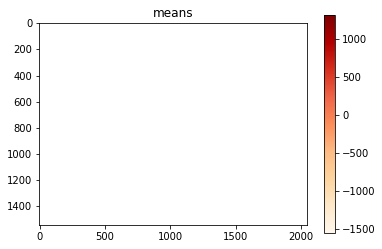

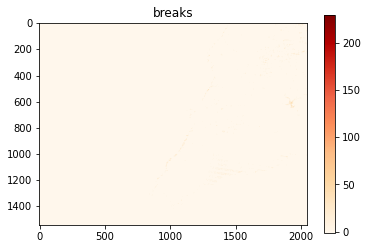

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000004096-0000002048/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000004096-0000002048_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000004096-0000002048_breaks.npy
minus2s:  0
minus1s:  3152245
total 3158016
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.18274131606679636
amount of nans in means:  3151214
breaks datatype:  int32
means datatype:  float32


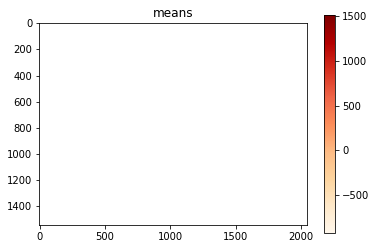

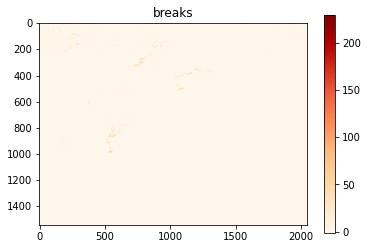

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000004096-0000004096/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000004096-0000004096_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000004096-0000004096_breaks.npy
minus2s:  0
minus1s:  3152367
total 3158016
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.17887813107976652
amount of nans in means:  3149173
breaks datatype:  int32
means datatype:  float32


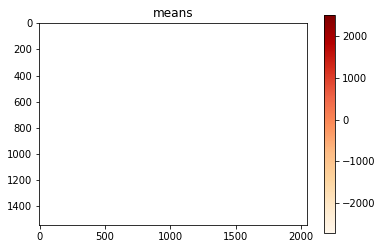

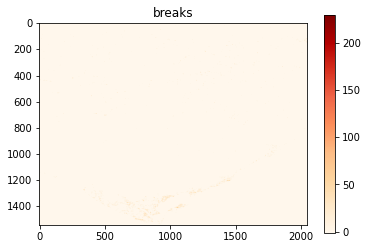

/home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000004096-0000006144/
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000004096-0000006144_means.npy
output_arrays/Time_series_2020-08-27_13-49-00_Portugal_all-8-tile-0000004096-0000006144_breaks.npy
minus2s:  0
minus1s:  1706717
total 1711620
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 0.2864537689440413
amount of nans in means:  1705398
breaks datatype:  int32
means datatype:  float32


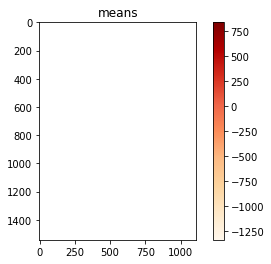

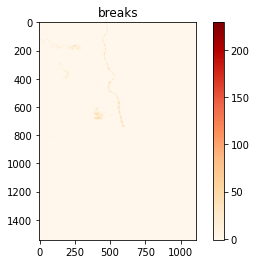

In [13]:
for tile in data_list:
    print(tile.dir)
    
    # do some plots
    breaks = tile.breaks_array#.astype("int") # it looks like for the new or big data you need to add astype("int") for means
    means = tile.means_array#.astype("int")
    
    tile.check_arrays(min_perc_lacking_data = 50)
    
    #means = means.astype('int')
    
    #plt.hist(means)
    #plt.show()
    
    print("breaks datatype: ",breaks.dtype)
    print("means datatype: ", means.dtype)
    im = plt.imshow(means, cmap=plt.cm.OrRd)
    plt.colorbar(im);
    plt.title('means')
    plt.show()
    
    im = plt.imshow(breaks, cmap=plt.cm.OrRd)
    plt.colorbar(im);
    plt.title('breaks')
    plt.show()
    
    
    #unique, counts = np.unique(means, return_counts=True)
    
    #print("mean counts")
    #print(np.asarray((unique, counts)).T[0:10])
    


In [16]:
for tile in data_list:
    print(tile.means_array.shape)


(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 1110)
(2048, 2048)
(2048, 2048)
(2048, 2048)
(2048, 1110)
(1542, 2048)
(1542, 2048)
(1542, 2048)
(1542, 1110)


In [12]:
# # So this is for merging tiles back together, it seems to work... but need to know for sure.. 
# # since it does not work in one direction, this one should be correct?



if len(data_list) > 1:
    
    big_means_array, big_breaks_array = merge_tiles(data_list)
    


y_tiles:  [[Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000000000/stack.vrt , Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000002048/stack.vrt , Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000004096/stack.vrt , Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000000000-0000006144/stack.vrt ], [Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000000000/stack.vrt , Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000002048/stack.vrt , Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000004096/stack.vrt , Timeseries: /home/dven/downloads/Time_series_2020-08-27_13-49-00_Portugal_all/8/tile-0000002048-0000006144/stack.vrt ], [Timeseries: /home/dven/downloads

## Run bfastmonitor() The loop_blocks code runs over smaller blocks, that may be set based on ram space or user itself..?


In [ ]:
# load all data at once? 

#     tile.load_breaks_means_arrays_from_file()
#     tile.start_hist = datetime(2018, 9, 14) # get these from log (automatically?) # probs save a dict as log
#     tile.end_monitor = datetime(2020, 8, 19) 
#     tile.crop_dates(dates)

# Select negative magnitudes

tiles


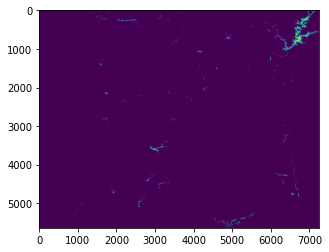

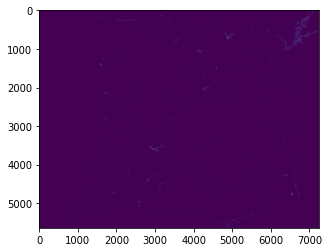

In [13]:
if len(data_list)>1:
    print("tiles")
    means = big_means_array.astype("int")
    breaks = big_breaks_array
else:
    breaks = data_list[0].breaks_array
    means = data_list[0].means_array.astype("int")

plt.imshow(means)
plt.show()
plt.imshow(breaks)
plt.show()


In [ ]:
# positive and negative

#means = data_list[0].means_array
#breaks = data_list[0].breaks_array

# no_breaks_indices = (breaks == -1)
# means[no_breaks_indices] = 0

# breaks_plot = breaks.astype(np.float)
# breaks_plot[breaks == -2] = np.nan
# breaks_plot[breaks == -1] = np.nan
# #breaks_plot[means >= 0] = np.nan


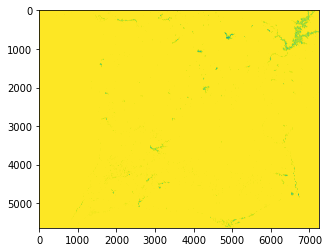

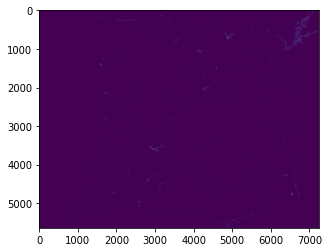

In [14]:
# import seaborn as sns

# select only negative magnitudes
no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan

# print("magnitude change heatmap")
# sns.heatmap(orig_means,  linewidths=1)

plt.imshow(means)
plt.show()
plt.imshow(breaks)
plt.show()


In [15]:
dates_monitor = []
dates = data_list[0].cropped_dates

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


# Classify output for plotting

In [16]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year+1):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
print(idx_starts)

breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))
    
    # if we're at the last year
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1 
        print("last")
        continue
    
    # if we're at the first year
    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        print("first")
        continue
    
    # all other years in between
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
    print("mid")

unique, counts = np.unique(breaks_plot_years, return_counts=True)
print(np.asarray((unique, counts)).T[0:10])


{2018: 0, 2019: 35, 2020: 162}
first
mid
last
[[0.0000e+00 7.8770e+03]
 [1.0000e+00 6.0711e+04]
 [2.0000e+00 1.1967e+04]
 [       nan 1.0000e+00]
 [       nan 1.0000e+00]
 [       nan 1.0000e+00]
 [       nan 1.0000e+00]
 [       nan 1.0000e+00]
 [       nan 1.0000e+00]
 [       nan 1.0000e+00]]


# Plot output

In [ ]:
bins = len(idx_starts)
# from matplotlib.pyplot import figure
# figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
print(bins)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(500, 500))

#norm doesn't work with bins = 2 or less... now the colorbar is ugly, fix it later

if bins == 1:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
if bins == 2:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
else:
    im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()



3


print(bounds)

In [ ]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [17]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [18]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [ ]:
print(latitude)
print(xpixelsize)
print(cols)
print(longitude)
print(ypixelsize)
print(rows)

In [ ]:
print(ts_data.latitude)
print(ts_data.longitude)

In [ ]:
# this is probs still wrong, maybe not though, we have to plot in a loop, maybe use ipy thing?

from folium.plugins import FloatImage
import base64
latitude = ts_data.latitude
longitude = ts_data.longitude
xpixelsize= ts_data.xpixelsize
ypixelsize= ts_data.ypixelsize
rows = ts_data.nrows
cols = ts_data.ncols

m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
#rows = 200
#cols = 200


# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + (rows*xpixelsize), longitude + (cols*xpixelsize)]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger_gpu.html'))
m